# 1. Data Acquisition

[*********************100%***********************]  1 of 1 completed

Downloaded Data:
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.796021  72.856613  71.545387  71.799873  135480400
2020-01-03  72.088287  72.851753  71.862884  72.020424  146322800
2020-01-06  72.662712  72.701492  70.954002  71.206070  118387200
2020-01-07  72.320976  72.929322  72.100418  72.672409  108872000
2020-01-08  73.484344  73.787308  72.022850  72.022850  132079200


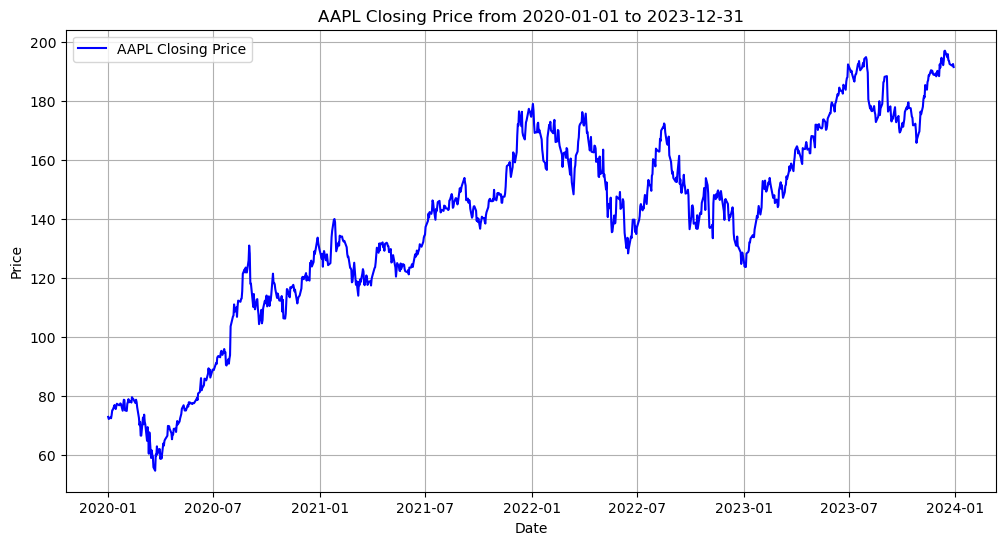

In [1]:
# Import required libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Define the ticker symbol and time period
ticker_symbol = 'AAPL'  # Example: Apple Inc.
start_date = '2020-01-01'
end_date = '2023-12-31'

# Fetch historical data using yfinance
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Display the first few rows of the data
print("Downloaded Data:")
print(stock_data.head())

# Plot the closing price
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'], label=f'{ticker_symbol} Closing Price', color='blue')
plt.title(f'{ticker_symbol} Closing Price from {start_date} to {end_date}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


# Save the data to a CSV file for further analysis (optional)
csv_filename = f"{ticker_symbol}_data.csv"
stock_data.to_csv(csv_filename)

# 2. Preprocessing

In [2]:
# Include 'Date' column in the new DataFrame
new_df = pd.DataFrame({
    'Date': stock_data.index,
    'Open': stock_data['Open'].values.ravel(),
    'High': stock_data['High'].values.ravel(),
    'Low': stock_data['Low'].values.ravel(),
    'Close': stock_data['Close'].values.ravel(),
    'Volume': stock_data['Volume'].values.ravel()
})

new_df['Close']

stock_data = new_df

# Calculate daily returns
stock_data['Daily_Returns'] = stock_data['Close'].pct_change()
initial_capital = 100000  # Initial investment capital in USD

# 3. Hyperparameter Grid

In [3]:
import pandas as pd
from sklearn.model_selection import ParameterGrid
import numpy as np

# Define hyperparameter grid
param_grid = {
    'short_window': [5, 10, 15],
    'long_window': [30, 50, 70],
    'stop_loss_pct': [0.02, 0.05, 0.1],
    'volatility_window': [10, 20, 30]
}

# Generate all combinations of hyperparameters
grid = ParameterGrid(param_grid)

# Set rolling window parameters
rolling_window_size = 252  # 1 year of trading days
step_size = 21  # Monthly step size

# 4/5 Training and Testing

In [4]:
# Store results
results = []
count = 0
test_period_results = []

# Function to calculate maximum drawdown
def calculate_max_drawdown(portfolio_values):
    peak = portfolio_values[0]
    max_drawdown = 0
    for value in portfolio_values:
        if value > peak:
            peak = value
        drawdown = (peak - value) / peak
        max_drawdown = max(max_drawdown, drawdown)
    return max_drawdown

# Perform rolling window backtesting
for start_idx in range(0, len(stock_data) - rolling_window_size, step_size):
    # Define training and testing period
    train_data = stock_data.iloc[start_idx:start_idx + rolling_window_size].copy()
    test_data = stock_data.iloc[start_idx + rolling_window_size - max(param_grid['long_window']):start_idx + rolling_window_size + step_size].copy()

    # Evaluate each hyperparameter combination on the training data
    for params in grid:
        # Extract hyperparameters
        short_window = params['short_window']
        long_window = params['long_window']
        stop_loss_pct = params['stop_loss_pct']
        volatility_window = params['volatility_window']

        # Apply strategy on training data
        train_data['Short_MA'] = train_data['Close'].rolling(window=short_window).mean()
        train_data['Long_MA'] = train_data['Close'].rolling(window=long_window).mean()
        train_data['Signal'] = 0
        train_data.loc[train_data['Short_MA'] > train_data['Long_MA'], 'Signal'] = 1
        train_data.loc[train_data['Short_MA'] <= train_data['Long_MA'], 'Signal'] = -1
        train_data['Volatility'] = train_data['Daily_Returns'].rolling(window=volatility_window).std()
        train_data['Normalized_Returns'] = train_data['Daily_Returns'] / train_data['Volatility']
        train_data['Position_Size'] = train_data['Signal'] * train_data['Normalized_Returns']

        # Perform backtest on training data
        cash = initial_capital
        stock_value = 0
        quantity = 0
        portfolio_values = []

        for i in range(1, len(train_data)):
            if train_data['Signal'].iloc[i] == 1:  # Buy signal
                entry_price = train_data['Close'].iloc[i]
                position_size = train_data['Position_Size'].iloc[i] * cash
                quantity += position_size / entry_price
                cash -= position_size
            elif train_data['Signal'].iloc[i] == -1:  # Sell signal
                exit_price = train_data['Close'].iloc[i]
                stock_value = quantity * exit_price
                cash += stock_value
                quantity = 0

            # Calculate current stock value for unrealized gain/loss
            stock_value = quantity * train_data['Close'].iloc[i]
            total_capital = cash + stock_value
            portfolio_values.append(total_capital)

        max_drawdown = calculate_max_drawdown(portfolio_values)
        cumulative_returns = (portfolio_values[-1] - initial_capital) / initial_capital
        sharpe_ratio = np.mean(train_data['Daily_Returns'].dropna()) / np.std(train_data['Daily_Returns'].dropna()) * np.sqrt(252)

        # Store results
        results.append({
            'params': params,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown': max_drawdown,
            'Cumulative Returns': cumulative_returns
        })

    # Apply the best hyperparameters to test data
    best_params = max(results, key=lambda x: x['Sharpe Ratio'])['params']

    # Apply strategy on test data
    test_data['Short_MA'] = test_data['Close'].rolling(window=best_params['short_window']).mean()
    test_data['Long_MA'] = test_data['Close'].rolling(window=best_params['long_window']).mean()
    test_data['Signal'] = 0
    test_data.loc[test_data['Short_MA'] > test_data['Long_MA'], 'Signal'] = 1
    test_data.loc[test_data['Short_MA'] <= test_data['Long_MA'], 'Signal'] = -1
    test_data['Volatility'] = test_data['Daily_Returns'].rolling(window=best_params['volatility_window']).std()
    test_data['Normalized_Returns'] = test_data['Daily_Returns'] / test_data['Volatility']
    test_data['Position_Size'] = test_data['Signal'] * test_data['Normalized_Returns']

    test_data = test_data.iloc[max(param_grid['long_window']):].copy()
    cash = initial_capital
    stock_value = 0
    quantity = 0
    portfolio_values = []

    for i in range(1, len(test_data)):
        if test_data['Signal'].iloc[i] == 1:  # Buy signal
            entry_price = test_data['Close'].iloc[i]
            position_size = test_data['Position_Size'].iloc[i] * cash
            quantity += position_size / entry_price
            cash -= position_size
        elif test_data['Signal'].iloc[i] == -1:  # Sell signal
            exit_price = test_data['Close'].iloc[i]
            stock_value = quantity * exit_price
            cash += stock_value
            quantity = 0

        # Calculate current stock value for unrealized gain/loss
        stock_value = quantity * test_data['Close'].iloc[i]
        total_capital = cash + stock_value
        portfolio_values.append(total_capital)

    max_drawdown = calculate_max_drawdown(portfolio_values)
    cumulative_returns = (portfolio_values[-1] - initial_capital) / initial_capital
    sharpe_ratio = np.mean(test_data['Daily_Returns'].dropna()) / np.std(test_data['Daily_Returns'].dropna()) * np.sqrt(252)

    test_period_results.append({
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Cumulative Returns': cumulative_returns
    })

# Calculate average metrics across test periods
average_sharpe_ratio = np.mean([result['Sharpe Ratio'] for result in test_period_results])
average_max_drawdown = np.mean([result['Max Drawdown'] for result in test_period_results])
average_cumulative_returns = np.mean([result['Cumulative Returns'] for result in test_period_results])

print("\nPerformance Summary Across Test Periods:")
print(f"Average Sharpe Ratio: {average_sharpe_ratio:.2f}")
print(f"Average Maximum Drawdown: {average_max_drawdown:.2%}")
print(f"Average Cumulative Returns: {average_cumulative_returns:.2%}")



Performance Summary Across Test Periods:
Average Sharpe Ratio: 1.14
Average Maximum Drawdown: 5.59%
Average Cumulative Returns: 0.20%


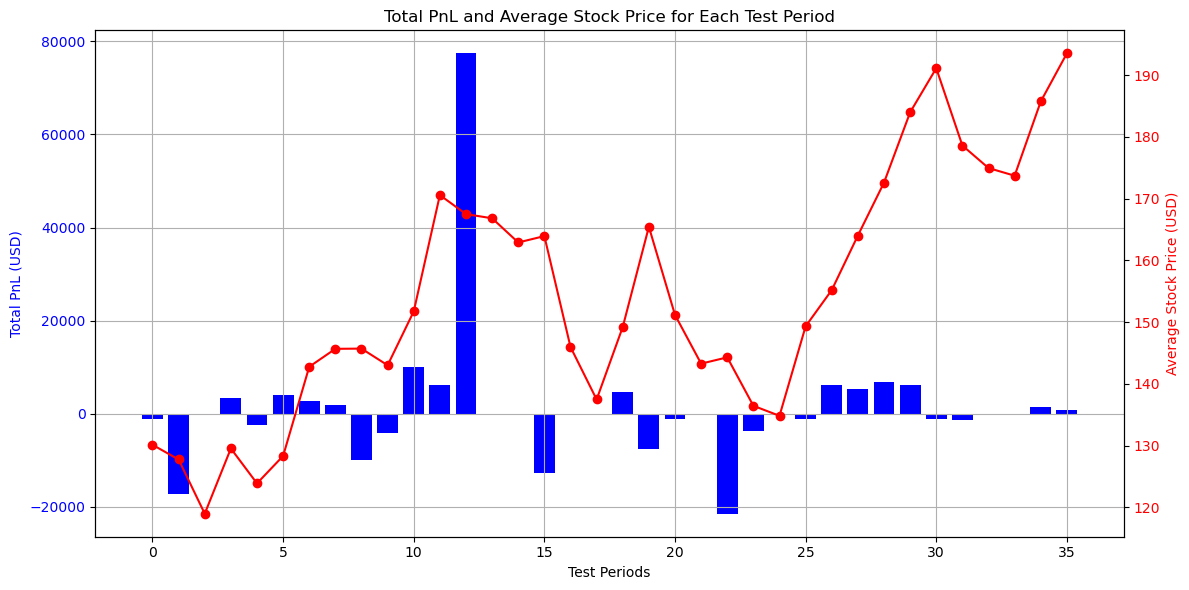


Best Overall Hyperparameters:
{'long_window': 50, 'short_window': 15, 'stop_loss_pct': 0.02, 'volatility_window': 10}
Total PnL: $235658.06
Sharpe Ratio: 1.46


In [17]:
# Store results
results = []
count  = 0
test_period_results = []
# Perform rolling window backtesting
for start_idx in range(0, len(stock_data) - rolling_window_size, step_size):
    # Define training and testing period
    train_data = stock_data.iloc[start_idx:start_idx + rolling_window_size].copy()
    test_data = stock_data.iloc[start_idx + rolling_window_size - max(param_grid['long_window']):start_idx + rolling_window_size + step_size].copy()

    # Evaluate each hyperparameter combination on the training data
    for params in grid:
        # Extract hyperparameters
        short_window = params['short_window']
        long_window = params['long_window']
        stop_loss_pct = params['stop_loss_pct']
        volatility_window = params['volatility_window']

        # Apply strategy on training data
        train_data['Short_MA'] = train_data['Close'].rolling(window=short_window).mean()
        train_data['Long_MA'] = train_data['Close'].rolling(window=long_window).mean()
        train_data['Signal'] = 0
        train_data.loc[train_data['Short_MA'] > train_data['Long_MA'], 'Signal'] = 1
        train_data.loc[train_data['Short_MA'] <= train_data['Long_MA'], 'Signal'] = -1
        train_data['Volatility'] = train_data['Daily_Returns'].rolling(window=volatility_window).std()
        train_data['Normalized_Returns'] = train_data['Daily_Returns'] / train_data['Volatility']
        train_data['Position_Size'] = train_data['Signal'] * train_data['Normalized_Returns']

        # Perform backtest on training data
        capital = initial_capital
        cash = initial_capital
        stock_value = 0
        quantity = 0
        pnl = []

        for i in range(1, len(train_data)):
            if train_data['Signal'].iloc[i] == 1:  # Buy signal
                entry_price = train_data['Close'].iloc[i]
                position_size = train_data['Position_Size'].iloc[i] * cash
                quantity += position_size / entry_price
                cash -= position_size
            elif train_data['Signal'].iloc[i] == -1:  # Sell signal
                exit_price = train_data['Close'].iloc[i]
                stock_value = quantity * exit_price
                pnl.append(stock_value - (quantity * entry_price))
                cash += stock_value
                quantity = 0

            # Calculate current stock value for unrealized gain/loss
            stock_value = quantity * train_data['Close'].iloc[i]
            total_capital = cash + stock_value  # Current portfolio value

        total_pnl = total_capital - initial_capital
        total_days = len(train_data)
        annual_pnl = total_pnl * (252 / total_days)
        sharpe_ratio = np.mean(train_data['Daily_Returns'].dropna()) / np.std(train_data['Daily_Returns'].dropna()) * np.sqrt(252)

        # Store results
        results.append({
            'params': params,
            'Total PnL': total_pnl,
            'Annual PnL': annual_pnl,
            'Sharpe Ratio': sharpe_ratio
        })

    # Apply the best hyperparameters to test data
    best_params = max(results, key=lambda x: x['Total PnL'])['params']

    # Apply strategy on test data
    test_data['Short_MA'] = test_data['Close'].rolling(window=best_params['short_window']).mean()
    test_data['Long_MA'] = test_data['Close'].rolling(window=best_params['long_window']).mean()
    test_data['Signal'] = 0
    test_data.loc[test_data['Short_MA'] > test_data['Long_MA'], 'Signal'] = 1
    test_data.loc[test_data['Short_MA'] <= test_data['Long_MA'], 'Signal'] = -1
    test_data['Volatility'] = test_data['Daily_Returns'].rolling(window=best_params['volatility_window']).std()
    test_data['Normalized_Returns'] = test_data['Daily_Returns'] / test_data['Volatility']
    test_data['Position_Size'] = test_data['Signal'] * test_data['Normalized_Returns']

    # Perform backtest on test data
    test_data = test_data.iloc[max(param_grid['long_window']):].copy()  # Drop extra rows used for rolling calculations
    cash = initial_capital
    stock_value = 0
    quantity = 0
    pnl = []
      # To store Total PnL for each test period

    for i in range(1, len(test_data)):
        if test_data['Signal'].iloc[i] == 1:  # Buy signal
            entry_price = test_data['Close'].iloc[i]
            position_size = test_data['Position_Size'].iloc[i] * cash
            quantity += position_size / entry_price
            cash -= position_size
        elif test_data['Signal'].iloc[i] == -1:  # Sell signal
            exit_price = test_data['Close'].iloc[i]
            stock_value = quantity * exit_price
            pnl.append(stock_value - (quantity * entry_price))
            cash += stock_value
            quantity = 0

        # Calculate current stock value for unrealized gain/loss
        stock_value = quantity * test_data['Close'].iloc[i]
        total_capital = cash + stock_value  # Current portfolio value

    total_pnl = total_capital - initial_capital
    realized_pnl = sum(pnl)
    total_days = len(test_data)
    annual_pnl = total_pnl * (252 / total_days)
    sharpe_ratio = np.mean(test_data['Daily_Returns'].dropna()) / np.std(test_data['Daily_Returns'].dropna()) * np.sqrt(252)
    # Append results for plotting
    # Calculate average price for the test period
    average_prices = test_data['Close'].mean()
    test_period_results.append({'period': count, 'Total PnL': total_pnl,'Average Price': average_prices})

    count += 1

# Plot all test period Total PnL results
# Plot all test period Total PnL results
fig, ax1 = plt.subplots(figsize=(12, 6))

periods = [result['period'] for result in test_period_results]
total_pnls = [result['Total PnL'] for result in test_period_results]
average_prices = [result['Average Price'] for result in test_period_results]

# Bar plot for Total PnL
ax1.bar(periods, total_pnls, color='blue', label='Total PnL')
ax1.set_xlabel('Test Periods')
ax1.set_ylabel('Total PnL (USD)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Total PnL and Average Stock Price for Each Test Period')
ax1.grid()

# Line chart for Average Stock Price
ax2 = ax1.twinx()
ax2.plot(periods, average_prices, color='red', marker='o', label='Average Stock Price')
ax2.set_ylabel('Average Stock Price (USD)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Adjust layout and show plot
fig.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()

# Summarize overall best results
best_overall_result = max(results, key=lambda x: x['Total PnL'])

print("\nBest Overall Hyperparameters:")
print(best_overall_result['params'])
print(f"Total PnL: ${best_overall_result['Total PnL']:.2f}")
print(f"Sharpe Ratio: {best_overall_result['Sharpe Ratio']:.2f}")